## LSTM介紹

RNN在訓練時會產生long-trem dependencies的問題，簡單來講就是RNN只能記得短期記憶，無法記得長期記憶

因此才發展出LSTM長短期記憶模型

## 匯入資料

In [1]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

/Users/andy/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# 移除html tag
import re
def rm_tags(text):
    re_tag = re.compile(r'<[^>]+>')
    return re_tag.sub('', text)

In [3]:
import os
def read_files(filetype):
    path = "data/aclImdb/"
    file_list=[]

    positive_path=path + filetype+"/pos/"
    for f in os.listdir(positive_path):
        file_list+=[positive_path+f]
    
    negative_path=path + filetype+"/neg/"
    for f in os.listdir(negative_path):
        file_list+=[negative_path+f]
        
    print('read',filetype, 'files:',len(file_list))
       
    all_labels = ([1] * 12500 + [0] * 12500) 
    
    all_texts  = []
    for fi in file_list:
        with open(fi,encoding='utf8') as file_input:
            all_texts += [rm_tags(" ".join(file_input.readlines()))]
            
    return all_labels,all_texts

In [4]:
y_train,train_text = read_files("train")

read train files: 25000


In [5]:
y_test,test_text = read_files("test")

read test files: 25000


In [6]:
# 建立token
token = Tokenizer(num_words=2000)
token.fit_on_texts(train_text)

In [7]:
# 轉換數字
x_train_seq = token.texts_to_sequences(train_text)
x_test_seq  = token.texts_to_sequences(test_text)

In [8]:
# 固定長度為100
x_train = sequence.pad_sequences(x_train_seq, maxlen=100)
x_test  = sequence.pad_sequences(x_test_seq,  maxlen=100)

## 建立LSTM模型

In [9]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM

In [10]:
model = Sequential()

In [11]:
# 加入Embedding層
model.add(Embedding(output_dim=32, # 輸出的維度為32，因為希望轉為32維度的向量
                    input_dim=2000, #輸入的維度為2000，因為先前建立的字典是2000字
                    input_length=100)) # 數字list長度為100
model.add(Dropout(0.2)) # 每次迭代隨機放棄20%神經元

In [12]:
# 加入LSTM層
model.add(LSTM(32)) # 32個神經元

In [13]:
# 加入隱藏層
model.add(Dense(units=256, # 隱藏層共有256個神經元，
                activation='relu'))
model.add(Dropout(0.35))

In [14]:
# 加入輸出層
model.add(Dense(units=1,
                activation='sigmoid'))

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           64000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               8448      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 81,025
Trainable params: 81,025
Non-trainable params: 0
_________________________________________________________________


In [16]:
# 設定模型參數，loss_function，optimizer，評估方式為accuracy
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])

In [17]:
#開始訓練
train_history = model.fit(x=x_train,
                          y=y_train,
                          validation_split=0.2, # keras會自動將80%作為訓練，20%測試，因此25000*0.8=20000為實際訓練資料
                          epochs=10, # 執行10次訓練週期
                          batch_size=100,verbose=2) # 每一批次100筆資料，所以每一次執行約為20000/100=200筆資料，verbose顯示訓練過程

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
 - 22s - loss: 0.4942 - acc: 0.7472 - val_loss: 0.4661 - val_acc: 0.7540
Epoch 2/10
 - 20s - loss: 0.3201 - acc: 0.8664 - val_loss: 0.4309 - val_acc: 0.8098
Epoch 3/10
 - 24s - loss: 0.2891 - acc: 0.8811 - val_loss: 0.4490 - val_acc: 0.7766
Epoch 4/10
 - 27s - loss: 0.2733 - acc: 0.8861 - val_loss: 0.4681 - val_acc: 0.8030
Epoch 5/10
 - 22s - loss: 0.2545 - acc: 0.8958 - val_loss: 0.5586 - val_acc: 0.7718
Epoch 6/10
 - 21s - loss: 0.2394 - acc: 0.9008 - val_loss: 0.4518 - val_acc: 0.8228
Epoch 7/10
 - 20s - loss: 0.2255 - acc: 0.9092 - val_loss: 0.6274 - val_acc: 0.7538
Epoch 8/10
 - 20s - loss: 0.2151 - acc: 0.9155 - val_loss: 0.7742 - val_acc: 0.7318
Epoch 9/10
 - 23s - loss: 0.2064 - acc: 0.9169 - val_loss: 0.6934 - val_acc: 0.7448
Epoch 10/10
 - 23s - loss: 0.1953 - acc: 0.9214 - val_loss: 0.6277 - val_acc: 0.7656


In [18]:
#以圖表顯示訓練過程
import matplotlib.pylab as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title("Train History")
    plt.ylabel(train)
    plt.xlabel("Epoch")
    plt.legend(['train','validation'], loc='upper left') #設定圖例
    plt.show()

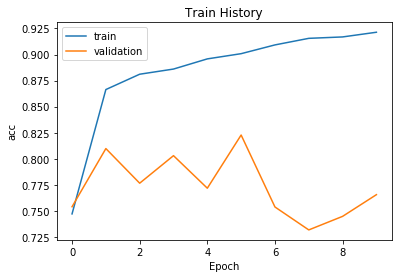

In [19]:
show_train_history(train_history, 'acc', 'val_acc')

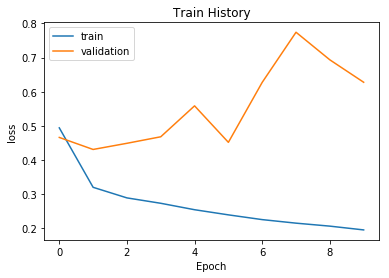

In [20]:
show_train_history(train_history, 'loss', 'val_loss')

In [21]:
#評估模型準確率
scores = model.evaluate(x_test, y_test, verbose=1)
print("accuracy=",scores[1])

25000/25000 [==============================] - 12s 493us/step